In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning


from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.express as px

import warnings

import seaborn as sns




In [43]:
data_t = pd.read_csv('prison_2010.txt', delimiter='\t', skiprows=2)
data_t = data_t.drop(range(53,58))

for col in data_t.columns:
   if not (data_t[col].apply(lambda x: isinstance(x, str))).all():
       continue
   
   if (data_t[col].apply(lambda x: isinstance(x, str)).all() & data_t[col].str.contains(',')).any():
        try:
            data_t[col] = data_t[col].replace('[\$,]', '', regex=True).astype(float)
        except AttributeError as err:
            print([col])
            break   
data_t = data_t.iloc[1:, :]

In [44]:
def processData(data, flag=False):
    df = data.iloc[:, 2:]
    # Create a boolean mask of NaN values
    nan_mask = df.isnull()

    # Check for any NaN values in each row
    nan_in_row = nan_mask.any(axis=1)

    # Check for any NaN values in each column
    nan_in_col = nan_mask.any(axis=0)
    rows_with_nans = df[nan_in_row]
    cols_with_nans = df.loc[:, nan_in_col]
    if flag:
        print("Features Containing NaN:", cols_with_nans)
    
    # Drop columns with NaN values and filter out columns containing "Population"
    # df = df.drop(columns=cols_with_nans).filter(regex='^(?!.*(Population)).*')
    df = df.drop(columns=cols_with_nans)



    # Add Percentages to DataFrame
    percent_men = getPercentage(df)[0]
    percent_women= getPercentage(df)[1]
    percent_both= getPercentage(df)[2]
    
    df = pd.concat([df, percent_men, percent_women, percent_both], axis=1)
    
    # Standardize the numerical features
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    scaler = StandardScaler()
    df_std = pd.DataFrame(scaler.fit_transform(df[num_cols]), columns=num_cols, index=df.index)
    df[df_std.columns] = df_std

    
    return df

def getX(df):
       X = df.iloc[:, 2:]
       return X

def runKmeans(data, X, n):
    kmeans = KMeans(n_clusters=n, init = 'k-means++', n_init=10)
    kmeans.fit(X)
    cluster_data = data.copy() 
    cluster_data['Cluster'] = kmeans.labels_
    return cluster_data

def runGaussian(data, X, n):
    X = X.filter(regex='^(?!.*(Total)).*')
    cluster_data = data.copy()

    # Fit a Gaussian Mixture Model with 4 clusters
    gmm = GaussianMixture(n_components=n)
    gmm.fit(X)

    # Get cluster predictions for each row
    clusters = gmm.predict(X)

    # Get probability scores for each row
    probs = gmm.predict_proba(X)

    # Add cluster and probability columns to original dataframe
    cluster_data['Cluster'] = clusters
    cluster_data['Probability'] = probs.max(axis=1)

    # Print the
    return cluster_data


def createBarChart(cluster_data, x_axis="Geography", y_axis="empty"): 
    fig = px.bar(cluster_data, x=x_axis, y=y_axis, color='Cluster')
    fig.show()

def stateClusterGraph(cluster_data):
    state_abbreviations = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
    }
    cluster_data['State Abbreviation'] = cluster_data['Geography'].map(state_abbreviations)


    # Create a choropleth map
    fig = px.choropleth(cluster_data, locations='State Abbreviation', locationmode='USA-states', color='Cluster', scope='usa', title='Clusters by State')

    # fig.show()
    return fig


def elbow_method(df, n):
    # Create a new DataFrame with only the columns you want to use for clustering
    X = df.iloc[:,1:6]

    # Perform K-means clustering for different values of K
    inertias = []
    for k in range(1, n):
        kmeans = KMeans(n_clusters=k, init = 'k-means++' , random_state=42, n_init=10).fit(X)
        inertia = kmeans.inertia_
        inertias.append(inertia)

    # Plot the elbow curve to choose the optimal value of K
    plt.plot(range(1, n), inertias, 'bx-')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal K')
    plt.show()

    # create dataframe for elbow plot data
    elbow_data = pd.DataFrame({
        'K': range(1, n),
        'Inertia': inertias
    })
    elbow_data = elbow_data.set_index('K')

    # print(elbow_data)

    # Calculate the slope and second derivative of the inertia curve
    slopes = [inertias[i+1] - inertias[i] for i in range(len(inertias)-1)]
    second_derivatives = [slopes[i+1] - slopes[i] for i in range(len(slopes)-1)]

    # Find the index of the maximum second derivative
    max_index = second_derivatives.index(max(second_derivatives))

    # The optimal value of K is one more than the index of the maximum second derivative
    best_k = max_index + 2
    # print(best_k)

    # return df, elbow_data, inertias, best_k


def correlationMap(df):
    # Select only the numeric columns
    numeric_columns = df.select_dtypes(include=['int64', 'float64'])
    
    # Calculate the correlation matrix
    corr_matrix = numeric_columns.corr()
    
    # Set the upper triangle to NaN
    corr_matrix = corr_matrix.where(np.tril(np.ones(corr_matrix.shape)).astype(np.bool))
    np.fill_diagonal(corr_matrix.values, np.nan)

    
    # Create a heatmap using seaborn
    plt.figure(figsize=(10, 7))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
    plt.title('Correlation of Numeric Features')
    plt.show()

def visualizing_results_2d(df, n):
    # Create a new DataFrame with only the columns you want to use for clustering
    X = df[['Incarceration rate', 'Female incarceration rate', 'Male incarceration rate']]

    # Create a KMeans instance with k = 3
    kmeans = KMeans(n_clusters=n, init = 'k-means++', n_init=10)
    # Fit the model to the data
    kmeans.fit(X)
    # Get the cluster assignments for each data point
    df['Cluster'] = kmeans.labels_

    # Get the cluster centroids
    centroids = kmeans.cluster_centers_

    # Create an empty figure
    fig = make_subplots(rows=3, cols=1, subplot_titles=(
        "IR by FIR", "IR by MIR", "FIR by MIR"))

    # Add a scatter plot of the data points to the first subplot
    fig.add_trace(
        go.Scatter(
            x=df['Incarceration rate'],
            y=df['Female incarceration rate'],
            mode='markers',
            marker=dict(
                color=df['Cluster']
            ),
            showlegend=False
        ),
        row=1,
        col=1
    )

    # Add a scatter plot of the centroids to the first subplot
    fig.add_trace(
        go.Scatter(
            x=centroids[:, 1],
            y=centroids[:, 0],
            mode='markers',
            marker=dict(
                size=10,
                color='red',
                symbol='star',
                line=dict(
                    width=1,
                    color='black'
                )
            ),
            name='Centroids'
        ),
        row=1,
        col=1
    )

    # Add a scatter plot of word_id by counts to the second subplot
    fig.add_trace(
        go.Scatter(
            x=df['Incarceration rate'],
            y=df['Male incarceration rate'],
            mode='markers',
            marker=dict(
                color=df['Cluster']
            ),
            showlegend=False
        ),
        row=2,
        col=1
    )

    # Add a scatter plot of doc_id by counts to the third subplot
    fig.add_trace(
        go.Scatter(
            x=df['Female incarceration rate'],
            y=df['Male incarceration rate'],
            mode='markers',
            marker=dict(
                color=df['Cluster']
            ),
            showlegend=False
        ),
        row=3,
        col=1
    )

    # Update the layout of the figure
    fig.update_layout(
        height=900,
        xaxis=dict(
            title='Incarceration rate'
        ),
        xaxis2=dict(
            title='Incarceration rate'
        ),
        xaxis3=dict(
            title='Female incarceration rate'
        ),
        yaxis=dict(
            title='Female incarceration rate'
        ),
        yaxis2=dict(
            title='Male incarceration rate'
        ),
        yaxis3=dict(
            title='Male incarceration rate'
        ),
        title='Clusters'
    )

    # Show the figure
    fig.show()

def getCorrectionalPopulation(df):
    # Use filter and regex pattern to separate columns into their own dataframes

    # filter columns based on gender
    male_cols = df.filter(regex='(Total Men|: Men$)').columns.tolist()
    female_cols = df.filter(regex='(Total Women|: Women$)').columns.tolist()
    both_cols = df.filter(regex='(: In Correctional Facilities for Adults|: in Correctional Facilities for Adults$)').columns.tolist()


    df_male = df[male_cols]
    df_female = df[female_cols]
    df_both = df[both_cols]


    drop_men_women = [col for col in df_both.columns if 'Men' in col or 'Women' in col]
    df_both = df_both.drop(drop_men_women, axis=1)

    return df_male, df_female, df_both

def getPercentage(df):
    corr_men = getCorrectionalPopulation(df)[0]
    corr_women = getCorrectionalPopulation(df)[1]
    corr_both = getCorrectionalPopulation(df)[2]
    percent_men = corr_men.div(df['Total Population: Male'], axis=0)*100
    percent_men.columns = ['Percent ' + col for col in percent_men.columns]

    percent_women = corr_women.div(df['Total Population: Female'], axis=0)*100
    percent_women.columns = ['Percent ' + col for col in percent_women.columns]

    percent_both = corr_both.div(df['Total Population'], axis=0)*100
    percent_both.columns = ['Percent ' + col for col in percent_both.columns]
    return percent_men, percent_women, percent_both

def getPopulation(df):
    # Use filter and regex pattern to separate columns into their own dataframes

    # filter columns based on gender
    male_cols = df.filter(regex=': Male$').columns.tolist()
    female_cols = df.filter(regex=': Female$').columns.tolist() 
    both_cols = df.filter(regex=': in Correctional Facilities for Adults$').columns.tolist()

    # create dataframes for male, female, and both
    df_male = df[male_cols]
    df_female = df[female_cols]
    df_both = df[both_cols]


## Raw Data
- After loading it data into data\_t we can then process and clean the data by calling processData() on it

In [45]:
df  = processData(data_t)

In [46]:
# correlationMap(processData(data_t))

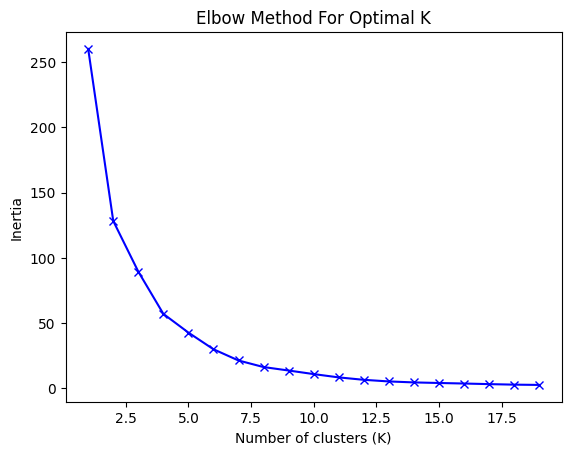

In [47]:
elbow_method(df, 20) ## Used to determine best k for K-means

In [48]:
n=4

In [49]:
visualizing_results_2d(processData(data_t),n)

## Plotting by Specific Features

### Step 1: Define the dataframes for each comparision (total, male, female)
- regex is used to include or exclude words we arent interested in for that word
```
regex='^(?!.*(Word|Another|Something)).*'

```
- In this case, regex will find colunm names that contain the phrases: "Word" or "Another" or "Something" (| = or)
- The carrort ^ symbol means to exclude, such as in $rate\_df\_total$
  - [Mm] is used to identify words that contain M or m in the colunms to exclude "M"ale and Fe"m"ale from the total dataframe
- Without the carrort, filter will focus on the words we specifies such as "Male" and "Female"

In [50]:
# Data frames that onyl consider Incarceration rates
rate_df_whole =processData(data_t).filter(regex='^(?!.*(Correctional|Percent|Population)).*') 
rate_df_total = rate_df_whole.filter(regex='^(?!.*([Mm]ale)).*') # Total rates
rate_df_male = rate_df_whole.filter(regex='.*(Geography|Male).*') # Male rates
rate_df_female = rate_df_whole.filter(regex='.*(Geography|[Fem]ale).*') # Female rates

### Step 2: Run K-means, get Feature and get n clusters
- runKmeans takes in 3 arguements: dataframe, feature variables (not the obsevations such as the states in our case), and the number of clusters we wish to use
### Step 3: Plots
- stateClusterGraph takes in the dataframe the runKmeans method (just includes cluster assigments) and plots them to states
#### Multiple Plots
- We can store the cluster data from the runKmeans method to different variables such as below 
- then Plot them on subplots as below

#### Single Plots
- Just calling stateClusterGraph with the cluster data passed as an argument and not defining it into a variable
- A plot will produce on its own


In [51]:
# Get graphs with State abbrevations assigned for each
total_rate_fig = stateClusterGraph(runKmeans(rate_df_total, getX(rate_df_total), n)) 
male_rate_fig= stateClusterGraph(runKmeans(rate_df_male, getX(rate_df_male), n))
female_rate_fig = stateClusterGraph(runKmeans(rate_df_female, getX(rate_df_female), n))

In [52]:
# Make 3 subplots for 
# Create a 1x3 grid of subplots with titles and a geo subplot type
fig = make_subplots(
    rows=1,
    cols=3,
    subplot_titles=('Total Rate', 'Male Rate', 'Female Rate'),
    specs=[[{'type': 'choropleth'}, {'type': 'choropleth'}, {'type': 'choropleth'}]]
)

# Add your figures as subplots
fig.add_trace(total_rate_fig.data[0], row=1, col=1)
fig.add_trace(male_rate_fig.data[0], row=1, col=2)
fig.add_trace(female_rate_fig.data[0], row=1, col=3)

# Update the geo attribute of each subplot to set the scope to 'usa'
fig.update_geos(scope='usa')

# Update the layout to show the subplots
fig.update_layout(title='Clusters by State')

fig.show()

In [53]:
full  = processData(data_t)
stateClusterGraph(runKmeans(full, getX(full), n))

In [54]:
createBarChart(runKmeans(full, getX(full), n), x_axis="Geography", y_axis='Total : In Correctional Facilities for Adults')


In [55]:
df

,Geography,Total : In Correctional Facilities for Adults,White alone : in Correctional Facilities for Adults,Black or African American alone : in Correctional Facilities for Adults,American Indian and Alaska Native alone : in Correctional Facilities for Adults,Asian alone : in Correctional Facilities for Adults,Native Hawaiian and other Pacific Islander alone : in Correctional Facilities for Adults,Some other race alone : in Correctional Facilities for Adults,Two or more races : in Correctional Facilities for Adults,Hispanic or Latino : in Correctional Facilities for Adults,...,Percent Total : In Correctional Facilities for Adults,Percent White alone : in Correctional Facilities for Adults,Percent Black or African American alone : in Correctional Facilities for Adults,Percent American Indian and Alaska Native alone : in Correctional Facilities for Adults,Percent Asian alone : in Correctional Facilities for Adults,Percent Native Hawaiian and other Pacific Islander alone : in Correctional Facilities for Adults,Percent Some other race alone : in Correctional Facilities for Adults,Percent Two or more races : in Correctional Facilities for Adults,Percent Hispanic or Latino : in Correctional Facilities for Adults,"Percent White alone, not Hispanic or Latino : in Correctional Facilities for Adults"
1,Alabama,-0.046607,-0.142180,0.242536,-0.567108,-0.394687,-0.297112,-0.338043,-0.266801,-0.359694,...,0.778557,0.116720,1.196984,-0.497613,-0.362543,-0.184697,-0.624849,-0.374025,-0.673932,0.452954
2,Alaska,-0.730722,-0.728050,-0.808617,0.717104,-0.413876,-0.175232,-0.372633,-0.132105,-0.421320,...,-0.393883,-0.759681,-1.028199,3.889943,0.049236,0.099612,-0.674099,4.931315,-0.626035,-0.521721
3,Arizona,0.432925,0.493162,-0.433127,5.182977,1.189169,2.680262,1.359909,2.033800,0.989995,...,1.566222,1.369571,-0.575191,1.579874,0.994442,0.542049,4.601887,1.792646,3.162997,0.481669
4,Arkansas,-0.329800,-0.295128,-0.301858,-0.491000,-0.309073,-0.276799,-0.301128,-0.408680,-0.345101,...,0.880933,0.780596,0.712382,-0.415384,-0.136074,-0.171999,-0.271594,-0.237207,-0.396694,1.097369
5,California,3.942558,3.880568,2.511116,2.521824,6.283193,2.273992,5.696049,5.345515,5.121527,...,0.066503,-0.087059,-0.262475,-0.334935,0.551467,-0.079390,2.447333,-0.011218,1.798686,-0.924720
6,Colorado,-0.057258,0.237743,-0.471527,0.800210,0.083570,-0.163624,-0.127081,0.324064,0.261083,...,0.552753,1.440971,-0.478093,0.131166,0.162876,-0.143385,0.198959,0.356482,1.597301,0.436373
7,Connecticut,-0.435323,-0.536433,-0.431118,-0.561860,-0.294312,-0.163624,0.204197,-0.329659,-0.133714,...,-0.465060,-1.123388,-0.043367,-0.482754,-0.172825,-0.125407,2.437310,-0.249085,0.594211,-1.003000
8,Delaware,-0.687509,-0.701335,-0.639618,-0.631844,-0.467016,-0.294210,-0.370309,-0.744521,-0.424627,...,0.186976,-0.551093,0.987194,-0.518012,-0.387369,-0.167352,-0.645914,-0.771358,-0.764604,-0.232386
9,District of Columbia,-0.740651,-0.784974,-0.673284,-0.618722,-0.446350,-0.302916,-0.363063,-0.602642,-0.419168,...,-0.330457,-2.266538,1.472125,-0.460769,-0.159756,-0.180010,-0.338767,0.919432,-0.499098,-2.207822
10,Florida,2.272557,2.295312,2.806172,-0.268800,0.180993,-0.201349,-0.048602,1.561467,0.746324,...,0.885585,0.659619,0.870586,-0.486142,-0.265006,-0.178864,-0.438882,-0.269886,0.199971,0.472555


In [56]:
# Data frames that onyl consider Incarceration percents
percent_df_whole =df.filter(regex='.*(Geography|Percent).*') 
percent_df_total = percent_df_whole.filter(regex='^(?!.*([Mm]en)).*') # Total percents
percent_df_male = percent_df_whole.filter(regex='.*(Geography|Men).*') # Male percents
percent_df_female = percent_df_whole.filter(regex='.*(Geography|[Wo]men).*') # Female percents

In [57]:
percent_df_whole.columns

Index(['Geography',
       'Percent Total Men : In Correctional Facilities for Adults',
       'Percent White alone: in Correctional Facilities for Adults : Men',
       'Percent Black or African American alone: in Correctional Facilities for Adults : Men',
       'Percent American Indian and Alaska Native alone: in Correctional Facilities for Adults : Men',
       'Percent Asian alone: in Correctional Facilities for Adults : Men',
       'Percent Native Hawaiian and other Pacific Islander alone: in Correctional Facilities for Adults : Men',
       'Percent Some other race alone: in Correctional Facilities for Adults : Men',
       'Percent Two or more races: in Correctional Facilities for Adults : Men',
       'Percent Hispanic or Latino: in Correctional Facilities for Adults : Men',
       'Percent White alone, not Hispanic or Latino: in Correctional Facilities for Adults : Men',
       'Percent Total Women : In Correctional Facilities for Adults',
       'Percent White alone: in Cor

In [58]:
percent_df_total.columns

Index(['Geography', 'Percent Total : In Correctional Facilities for Adults',
       'Percent White alone : in Correctional Facilities for Adults',
       'Percent Black or African American alone : in Correctional Facilities for Adults',
       'Percent American Indian and Alaska Native alone : in Correctional Facilities for Adults',
       'Percent Asian alone : in Correctional Facilities for Adults',
       'Percent Native Hawaiian and other Pacific Islander alone : in Correctional Facilities for Adults',
       'Percent Some other race alone : in Correctional Facilities for Adults',
       'Percent Two or more races : in Correctional Facilities for Adults',
       'Percent Hispanic or Latino : in Correctional Facilities for Adults',
       'Percent White alone, not Hispanic or Latino : in Correctional Facilities for Adults'],
      dtype='object')

In [81]:
stateClusterGraph(runKmeans(percent_df_total, getX(percent_df_total), n))

In [68]:
createBarChart(runGaussian(percent_df_total, getX(percent_df_total), n), x_axis="Geography", y_axis='Percent Total : In Correctional Facilities for Adults')


In [82]:
stateClusterGraph(runGaussian(percent_df_total, getX(percent_df_total), n))

In [ ]:
from sklearn.decomposition import PCA

# Project the data onto two dimensions using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a scatter plot of the projected data
fig = px.scatter(x=X_pca[:, 0], y=X_pca[:, 1], color=labels)

# Add axis labels and a title
fig.update_layout(
    xaxis_title='PCA 1',
    yaxis_title='PCA 2',
    title='Gaussian Clustering Results'
)

# Show the plot
fig.show()